# 03 Binary Classification
**Adapted from Deep Learning with Pyton by Francois Chollet**

https://github.com/fchollet/deep-learning-with-python-notebooks

## The IMDB Dataset


"IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

The IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.


In [2]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import keras

Using TensorFlow backend.


In [4]:
# problems with numpy latest version and load_data()

from keras.datasets import imdb

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. 

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [5]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [6]:
train_labels[0]

1

Here's how to decode one of these reviews back to English words:

In [7]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# we reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# we decode the review; our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the Data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors:

one-hot-encode our lists to turn them into vectors of 0s and 1s. This means for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

In [9]:
def vectorize_sequences(sequences, dimension=10000):
    # create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# our vectorized training data
x_train = vectorize_sequences(train_data)
# our vectorized test data
x_test = vectorize_sequences(test_data)

In [12]:
import sys
sys.getsizeof(word_index)/1024/1024

5.000099182128906

In [13]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Vectorize labels:

In [14]:
# vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Building the Network


Our input data is simply vectors, and our labels are scalars (1s and 0s). A type of network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer.

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

Here, the following architecture choice: 
two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

In [15]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

W0815 13:21:34.250497 139640568145728 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 13:21:34.282065 139640568145728 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 13:21:34.285051 139640568145728 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



We need to pick a **loss function** and an **optimizer**. This is a binary classification problem and the output of the network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
Crossentropy is usually the best choice when you 
are dealing with models that output probabilities. 

We choose the `rmsprop` optimizer, generally a good choice whatever the problem. To configure the parameters of your optimizer pass an optimizer class instance as the `optimizer` argument:

In [16]:
# option 1
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

W0815 13:21:35.399394 139640568145728 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 13:21:35.426634 139640568145728 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0815 13:21:35.434593 139640568145728 deprecation.py:323] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
# option 2, optimozer class
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Validatinon 

Create a validation set to monitor accuracy during training on data that it has never seen before:

In [18]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 samples. We will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the validation data as the `validation_data` argument:

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

W0815 13:21:37.344818 139640568145728 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 168us/step - loss: 0.4976 - acc: 0.7953 - val_loss: 0.3717 - val_acc: 0.8721
Epoch 2/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.2957 - acc: 0.9045 - val_loss: 0.2989 - val_acc: 0.8910
Epoch 3/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.2160 - acc: 0.9286 - val_loss: 0.3087 - val_acc: 0.8714
Epoch 4/20
15000/15000 [==============================] - 2s 127us/step - loss: 0.1742 - acc: 0.9433 - val_loss: 0.2831 - val_acc: 0.8839
Epoch 5/20
15000/15000 [==============================] - 2s 127us/step - loss: 0.1414 - acc: 0.9543 - val_loss: 0.2863 - val_acc: 0.8848
Epoch 6/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1143 - acc: 0.9653 - val_loss: 0.3074 - val_acc: 0.8817
Epoch 7/20
15000/15000 [==============================] - 2s 127us/step - loss: 0.0969 - acc: 0.9711 - val_loss: 0.3147 - 

`model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data about everything that happened during training. 

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

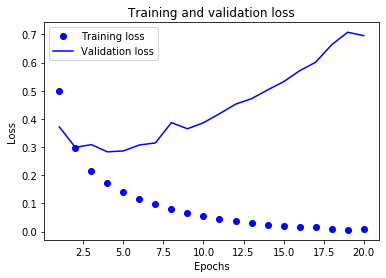

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend();

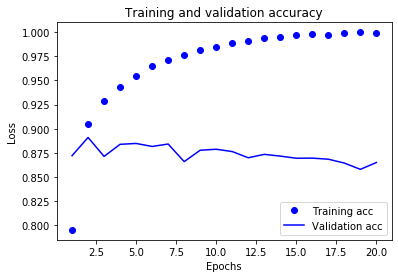

In [22]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy.

The training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would 
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that 
isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch: this is "overfitting".

In this case, to prevent overfitting, we could simply stop training after three epochs. 

Let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [23]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 97us/step - loss: 0.4749 - acc: 0.8216
Epoch 2/4
25000/25000 [==============================] - 2s 80us/step - loss: 0.2668 - acc: 0.9096
Epoch 3/4
25000/25000 [==============================] - 2s 82us/step - loss: 0.1987 - acc: 0.9291
Epoch 4/4
25000/25000 [==============================] - 3s 103us/step


In [24]:
results

[0.32446606307029724, 0.87272]

### Predictions on New Data

You can generate the likelihood of reviews being positive 
by using the `predict` method:

In [25]:
model.predict(x_test)

array([[0.13587797],
       [0.99970984],
       [0.28030333],
       ...,
       [0.07126471],
       [0.04230773],
       [0.4725048 ]], dtype=float32)

### Exercises


* Use 1 or 3 hidden layers and see how it affects validation and test accuracy.
* Use layers with more hidden units or less hidden units: 32 units, 64 units.
* Use the `mse` loss function instead of `binary_crossentropy`.
* Use the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.